In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
import theano.tensor as th

In [2]:
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    
    result = a[np.where((a >= quartileSet[0]) & (a <= quartileSet[1]))]
    
    return result.tolist()

In [3]:
phantom_data=scipy.io.loadmat('Bay1_Helmut.mat')

In [4]:
gt = phantom_data["Ground_Truth"]
fmri = phantom_data["fMRI_Output"]

In [5]:
gt_mean = np.mean(gt,axis=1)
fmri_mean = np.mean(gt,axis=1)
gt_std = np.std(gt,axis=1)
fmri_std = np.std(fmri,axis=1)
gt_skew = sp.stats.skew(gt,axis=1)
fmri_skew = sp.stats.skew(fmri,axis=1)

gt_nooutliers = removeOutliers(gt_skew,1.5)
fmri_nooutliers = removeOutliers(fmri_skew,4.0)
print(len(gt_skew)-len(gt_nooutliers),len(fmri_skew)-len(fmri_nooutliers))

7 31


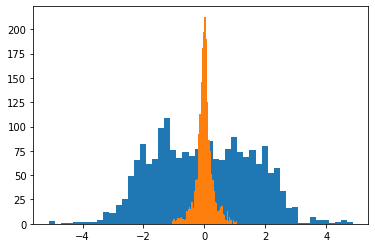

In [6]:
_=plt.hist(gt_nooutliers,bins=50)
_=plt.hist(fmri_nooutliers,bins=50)

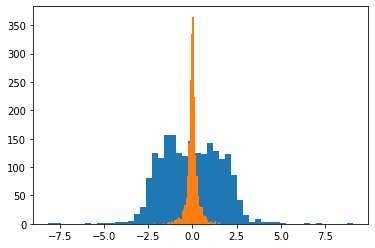

In [7]:
skew_idx = np.argsort(gt_nooutliers)
_=plt.hist(gt_skew,bins=50)
_=plt.hist(fmri_skew,bins=50)

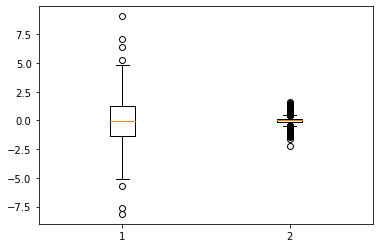

In [8]:
_ = plt.boxplot([gt_skew,fmri_skew])

In [9]:
gt_norm = (gt - gt_mean[:,np.newaxis])/gt_std[:,np.newaxis]
fmri_norm = (fmri - fmri_mean[:,np.newaxis])/fmri_std[:,np.newaxis]

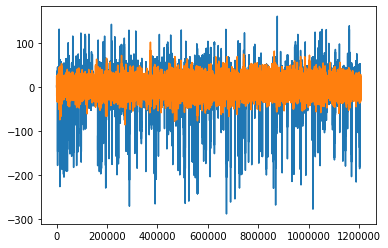

In [10]:
idx = 800
gt_data = gt[skew_idx].flatten()
fmri_data = fmri[skew_idx].flatten()
plt.plot(gt_data)
plt.plot(fmri_data)

In [11]:
# here we assume that the two distributions add
with pm.Model() as multi_noise:
    sigma1 = pm.Uniform('sigma1',0,20)
    ampl1 = pm.Uniform('ampl1',0,5)
    
    fmri_observed = pm.Normal('fmri_observed',
                              mu=gt_data,
                              sigma=np.sqrt(sigma1**2+ampl1**2*np.abs(gt_data)**2), observed=fmri_data)

    posterior_2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ampl1, sigma1]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [03:48<00:00,  8.74draws/s] 
The acceptance probability does not match the target. It is 0.886840503270675, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8940653725384063, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c6fd253c8>,
      dtype=object)

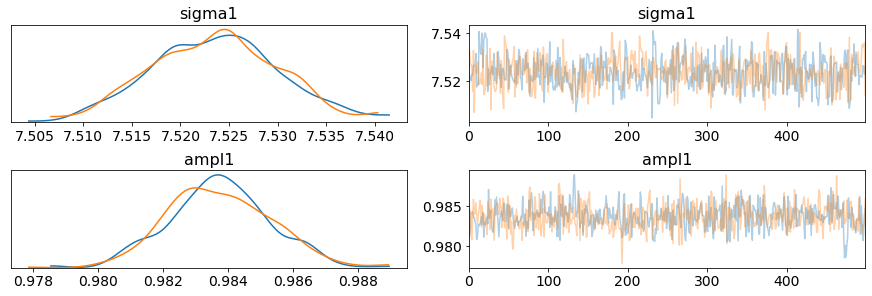

In [12]:
pm.traceplot(posterior_2)

In [13]:
pm.summary(posterior_2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma1,7.524,0.007,7.512,7.536,0.0,0.0,660.0,659.0,652.0,455.0,1.00
ampl1,0.984,0.002,0.981,0.986,0.0,0.0,696.0,696.0,732.0,644.0,1.01


In [14]:
# now we want to see what are the contributions to the noise
sigma_mult = np.sqrt(np.sum(0.984**2*gt_data**2)/len(gt_data))
sigma_total = np.sqrt(np.sum(0.984**2*gt_data**2+7.523**2)/len(gt_data))
print(sigma_mult,np.std(gt_data),sigma_total)

16.193261275619278 16.45656633701145 17.85545406144775


In [15]:
# here is a more realistic model
#with pm.Model() as multi_noise2:
#    sigma1 = pm.Uniform('sigma1',0,5)
#    ampl1 = pm.Uniform('ampl1',0,5)
#    noise_thermal = pm.Normal('noise_thermal',mu=gt_data, sigma=sigma1,shape=len(gt_data))
#    noise_multi = pm.Normal('noise_multi',mu=0, sigma=ampl1*np.abs(gt_data),shape=len(gt_data))
    
#    fmri = pm.Deterministic('fmri', noise_thermal + noise_multi)
#    fmri_observed = pm.Normal('fmri_observed', mu=fmri, tau=10000,observed=fmri_data)

#    posterior = pm.sample(2000, tune=1000)

In [16]:
#pm.traceplot(posterior['sigma1'])

In [17]:
#pm.traceplot(posterior['ampl1'])